In [1]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.1 🚀 Python-3.11.3 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
Setup complete ✅ (16 CPUs, 31.9 GB RAM, 1737.7/1863.0 GB disk)


# 1. Real data

### 1.1 Import dataset

In [1]:
from roboflow import Roboflow
rf = Roboflow(api_key="YOUR_API_KEY")
project = rf.workspace("resource-project").project("realfire")
dataset = project.version(2).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics<=8.0.20 is required but found version=8.1.1, to fix: `pip install ultralytics<=8.0.20`


Extracting Dataset Version Zip to realFire-2 in yolov8:: 100%|██████████| 10950/10950 [00:03<00:00, 2814.62it/s]


### 1.2 Train custom model

In [ ]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt")

results = model.train(data="realFire-2/data.yaml", epochs=300, device='0', batch=-1)

### 1.3 Visualisation

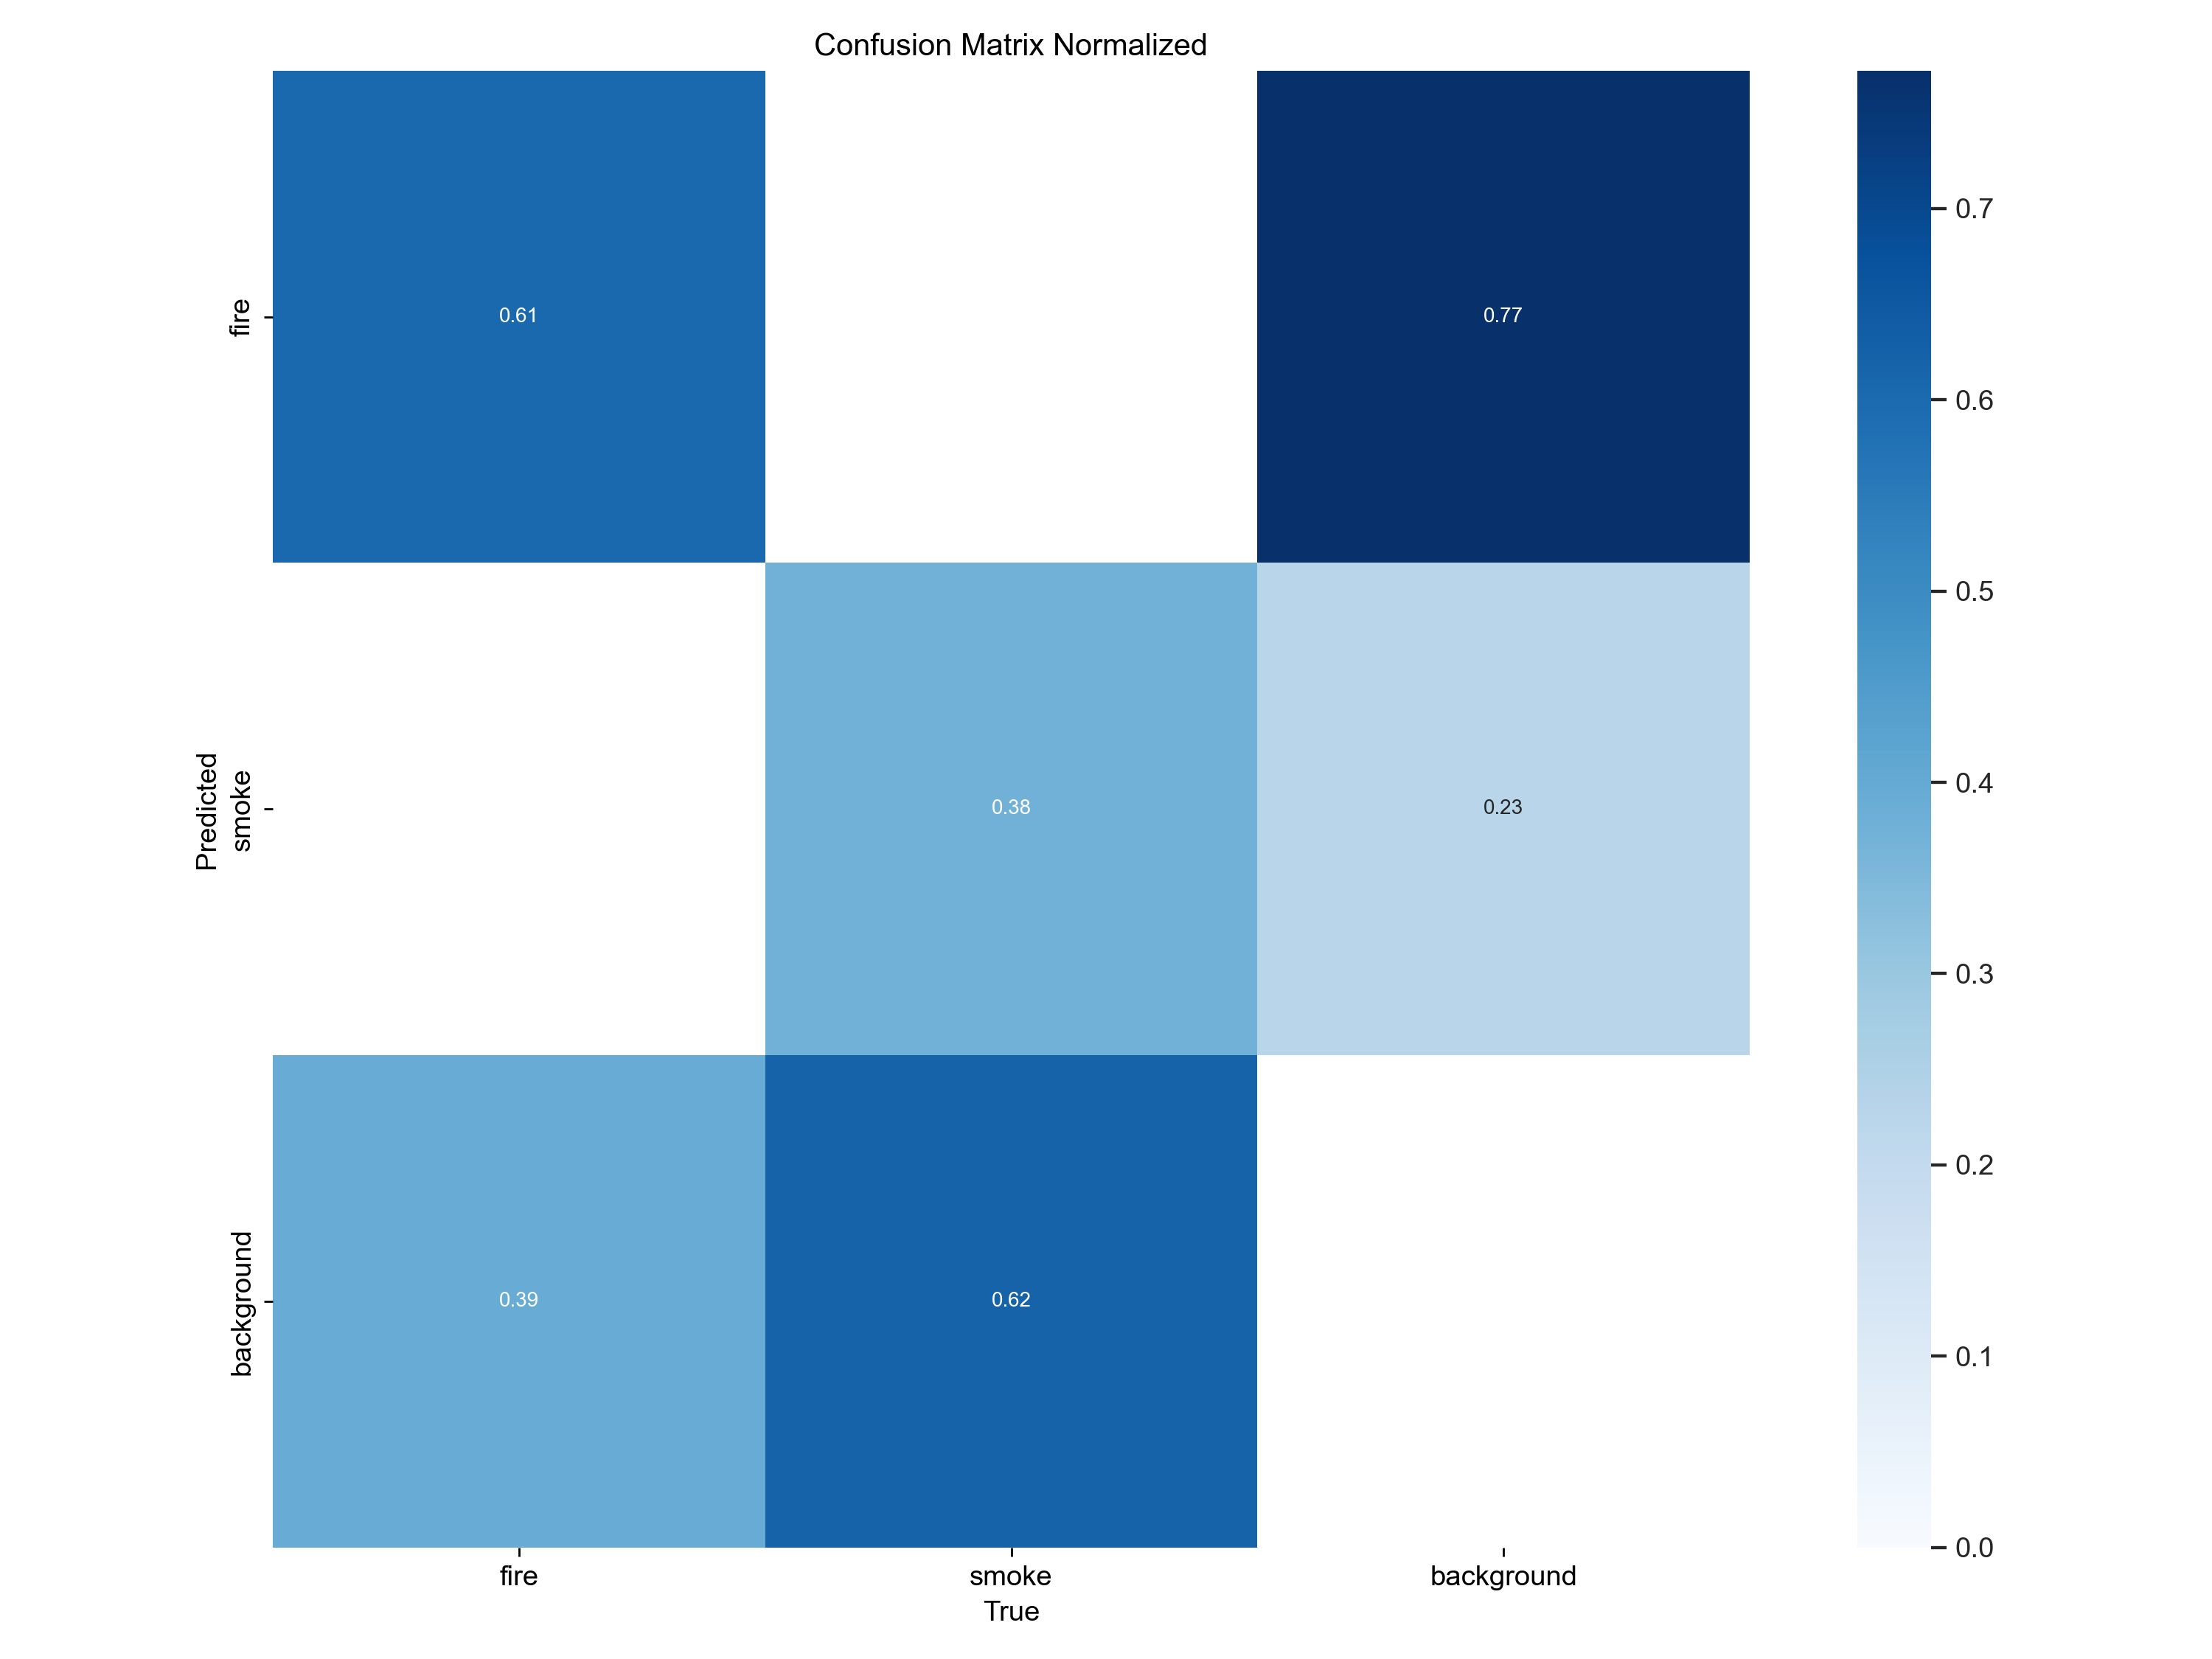

In [11]:
from IPython.display import Image

Image(filename='runs/detect/full/confusion_matrix_normalized.png', width=1000)

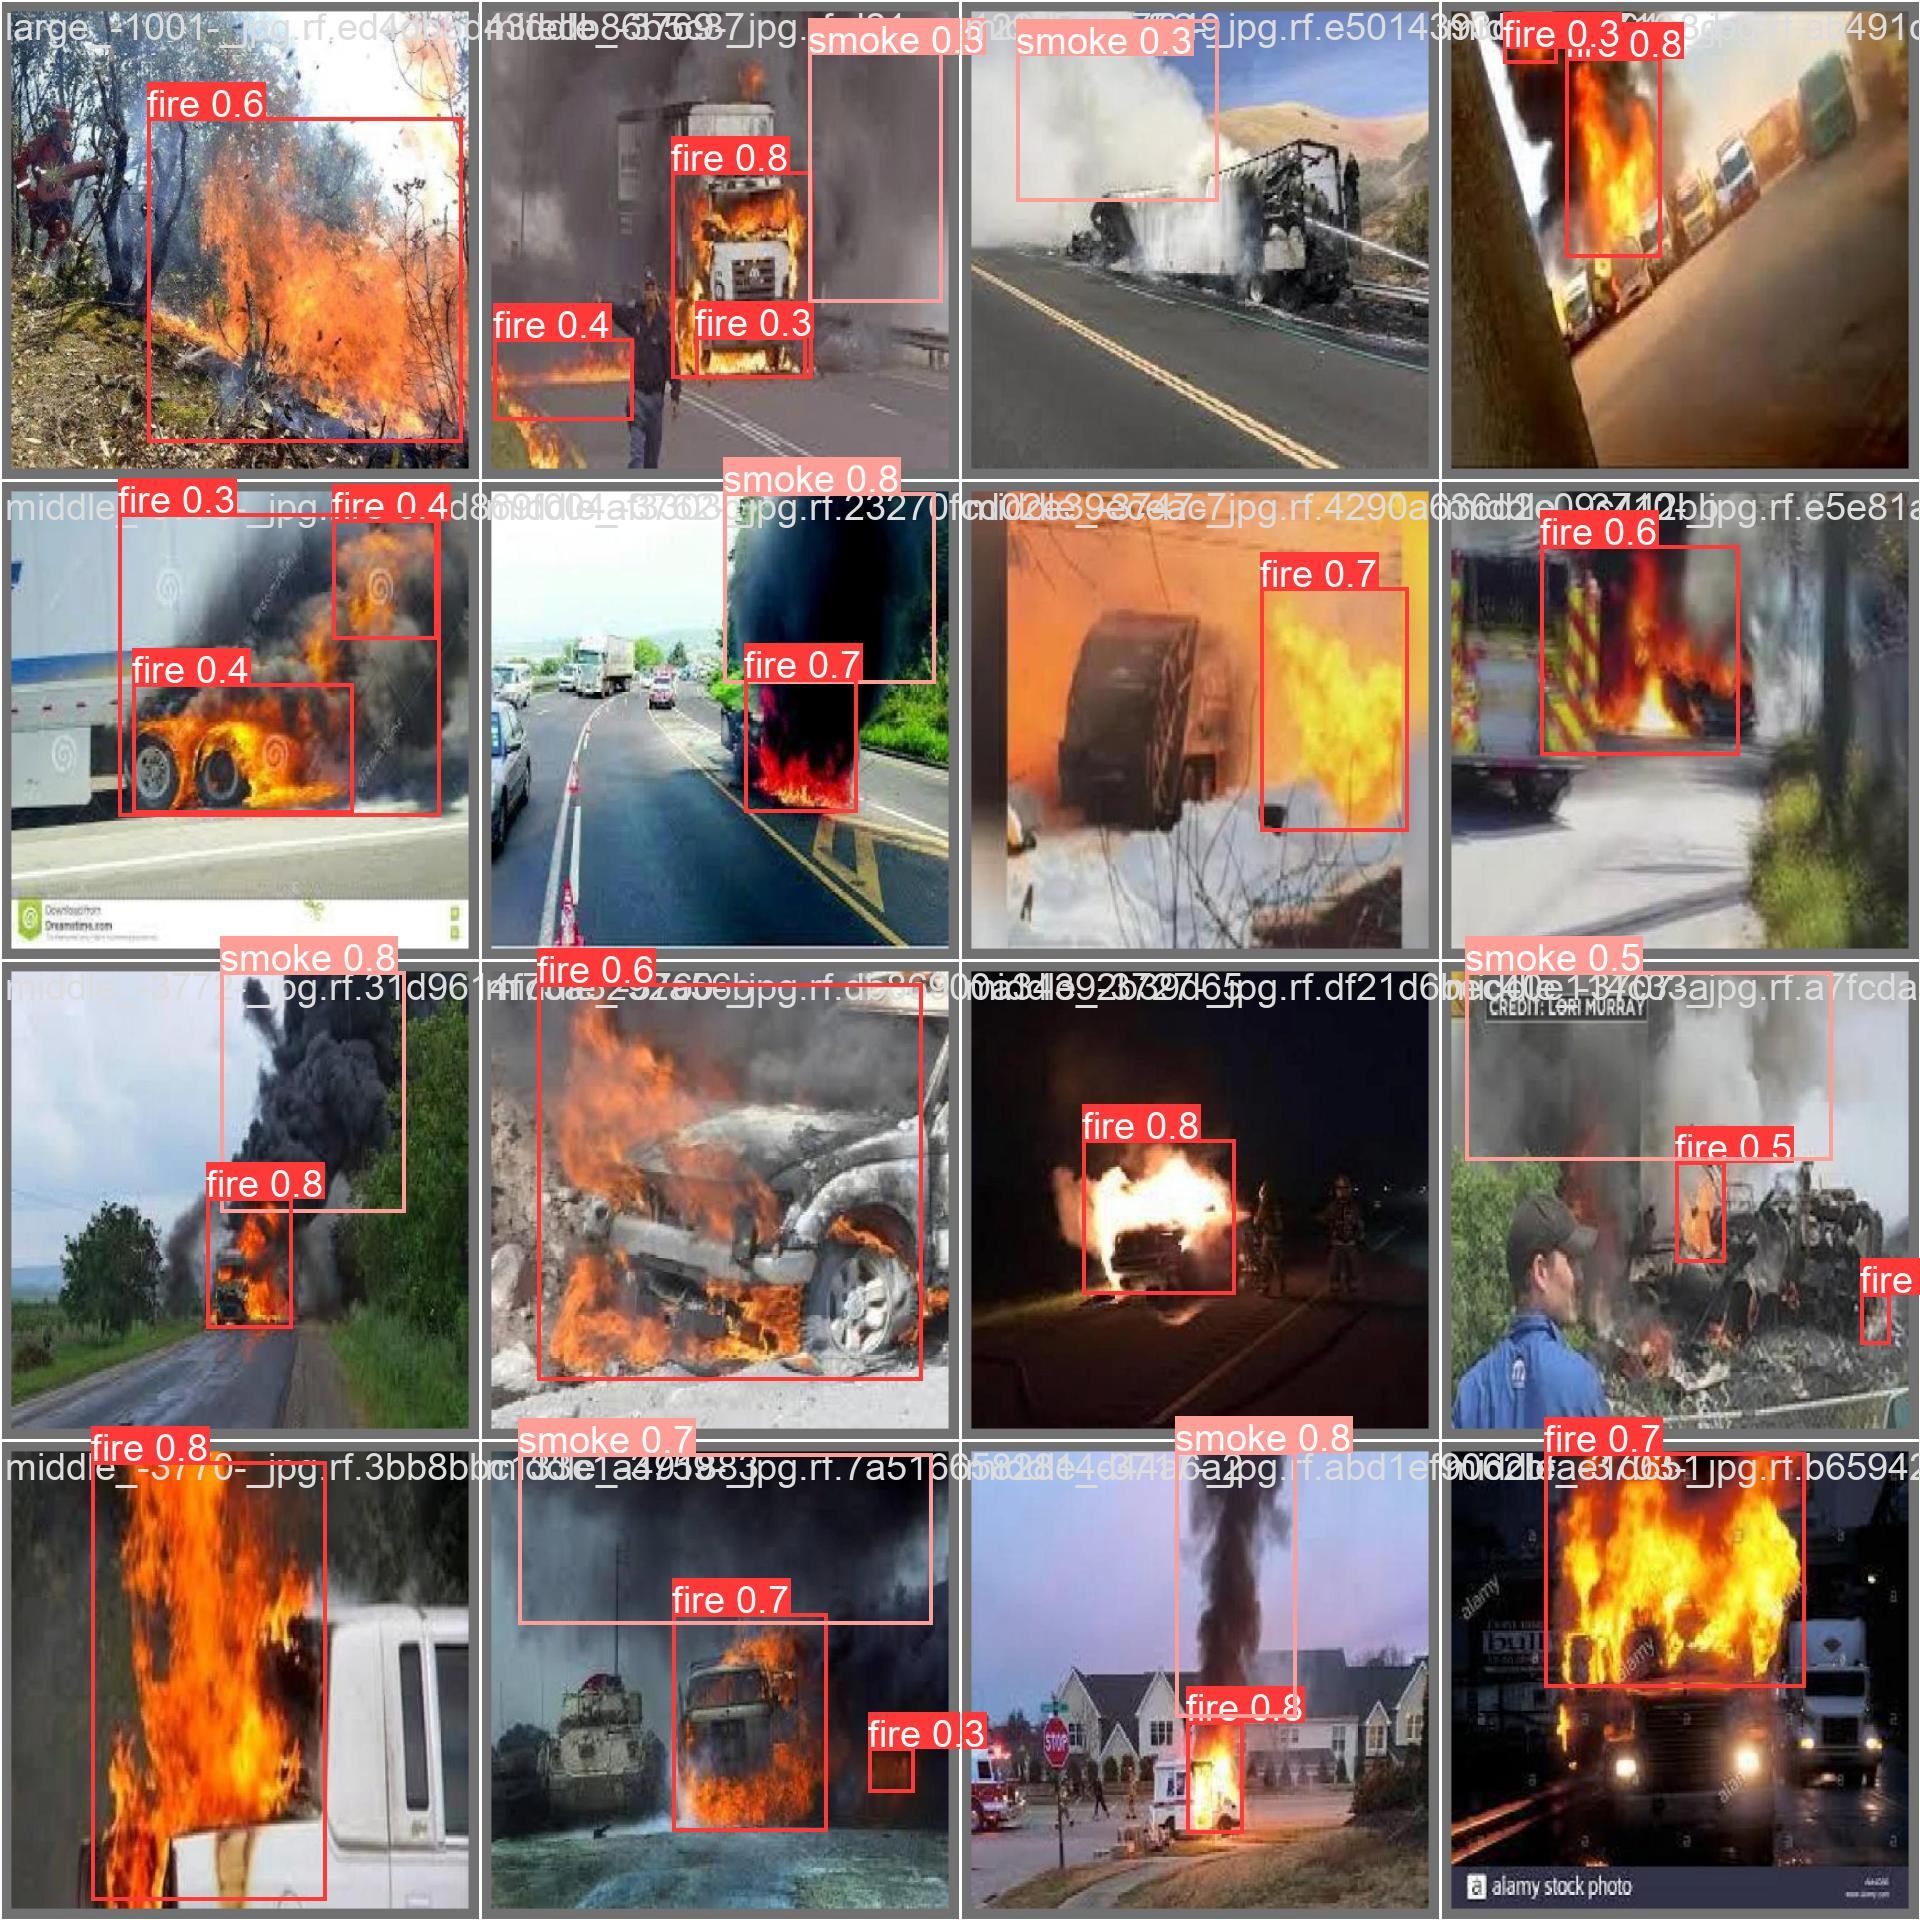

In [12]:
Image(filename='runs/detect/full/val_batch0_pred.jpg', width=1000)

### 1.4 Validation on static testset

In [1]:
from ultralytics import YOLO

# Load a model
model = YOLO('runs/detect/full/weights/best.pt')  # load a custom model

# Validate the model
metrics = model.val(data="testset-2/data.yaml", imgsz=640, save_json=True)  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category

Ultralytics YOLOv8.1.1 🚀 Python-3.11.3 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\ResearchProject\testset-2\valid\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.38it/s]


                   all        100        235      0.826      0.603      0.746      0.442
                  fire        100        171       0.83      0.643      0.792      0.475
                 smoke        100         64      0.822      0.562        0.7       0.41
Speed: 1.3ms preprocess, 4.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Saving runs\detect\val2\predictions.json...
Results saved to runs\detect\val2


array([    0.47491,     0.40972])

In [7]:
metrics.box.map50 * 100

74.59904486200261

### 1.5 Running inference

In [ ]:
!yolo task=detect mode=predict model="runs/detect/full/weights/best.pt" source="D:/ComfyUI/ComfyUI_windows_portable_nvidia_cu121_or_cpu/ComfyUI_windows_portable/ComfyUI/output_forest/ComfyUI_00901_.png" conf=0.25 line_width=1

In [ ]:
!yolo task=detect mode=predict model="runs/detect/full/weights/best.pt" source="fire/fire3.mp4" conf=0.2 line_width=1

### 1.5 Upload

In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key="YOUR_API_KEY")
project = rf.workspace().project("realfire")
project.version(2).deploy(model_type="yolov8", model_path=f"./runs/detect/full/")

# 2 Synthetic data

### 2.1 Auto-label synthetic data

In [ ]:
import os
import torch
from tqdm import tqdm
from PIL import Image
from torchvision.ops import nms
from transformers import Owlv2Processor, Owlv2ForObjectDetection

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def convert_to_yolo_format(image_size, box, label):
    # Convert bounding box coordinates to YOLO format
    xmin, ymin, xmax, ymax = box
    width, height = image_size
    x_center = (xmin + xmax) / 2 / width
    y_center = (ymin + ymax) / 2 / height
    box_width = (xmax - xmin) / width
    box_height = (ymax - ymin) / height
    return f"{label} {x_center:.6f} {y_center:.6f} {box_width:.6f} {box_height:.6f}"

# def process_folder(input_folder, output_folder, nms_threshold=0.2, threshold=0.1):

def process_folder(input_folder, output_folder, nms_threshold=0.2):
    # Create output folders
    image_output_folder = os.path.join(output_folder, "images")
    label_output_folder = os.path.join(output_folder, "labels")
    os.makedirs(image_output_folder, exist_ok=True)
    os.makedirs(label_output_folder, exist_ok=True)

    # Load OwlV2 processor
    processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")

    # Load OwlV2 object detection model
    model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble").to(device)

    # Loop through all images in the input folder with tqdm
    for filename in tqdm(os.listdir(input_folder), desc="Processing images", unit="image"):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            file_path = os.path.join(input_folder, filename)

            # Load image
            image = Image.open(file_path)

            # Provide text descriptions for the image
            texts = [["fire", "smoke"]]

            # Tokenize and process inputs
            inputs = processor(text=texts, images=image, return_tensors="pt").to(device)

            # Get raw model outputs
            outputs = model(**inputs)

            # Target image sizes (height, width) to rescale box predictions [batch_size, 2]
            target_sizes = torch.Tensor([image.size[::-1]]).to(device)

            # Convert outputs (bounding boxes and class logits) to Pascal VOC Format (xmin, ymin, xmax, ymax)
            results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes)
                                                              
            # WITH NORMAL TRESHOLD
            # results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=threshold)


            # Apply NMS thresholding to the results
            for result in results:
                boxes, scores, labels = result["boxes"], result["scores"], result["labels"]
                keep = nms(boxes, scores, nms_threshold)
                result["boxes"] = boxes[keep]
                result["scores"] = scores[keep]
                result["labels"] = labels[keep]

            # Retrieve predictions for the first image for the corresponding text queries
            i = 0
            text = texts[i]
            boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

            # Write YOLO format annotations to a text file
            annotation_filename = os.path.splitext(filename)[0] + ".txt"
            annotation_path = os.path.join(label_output_folder, annotation_filename)
            with open(annotation_path, "w") as output_file:
                for box, score, label in zip(boxes, scores, labels):
                    box = [round(i, 2) for i in box.tolist()]
                    yolo_annotation = convert_to_yolo_format(image.size[::-1], box, label)
                    output_file.write(f"{yolo_annotation}\n")

            # Save the image to the output folder
            image.save(os.path.join(image_output_folder, filename))

    print(f"Dataset created in {output_folder}")

# Specify input and output folders
input_folder = "owlv2_outputs/test"
output_folder = "owlv2_NMS/campfire"

# Process the folder
process_folder(input_folder, output_folder)


#### After auto-labeling select the output folder and import the dataset to roboflow to make your dataset and model management easier.

#### If you don't want to do this, skip to 2.3

### 2.2 Download labeled synthetic dataset

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="YOUR_API_KEY")
project = rf.workspace("synthetic-real").project("r50s50-25")
dataset = project.version(1).download("yolov8")


### 2.3 Train custom model

In [ ]:
from ultralytics import YOLO
model = YOLO("yolov8n.pt")

results = model.train(data="synethic-1500-1/data.yaml", epochs=300, device='0', batch=-1)

### 2.4 Visualisation

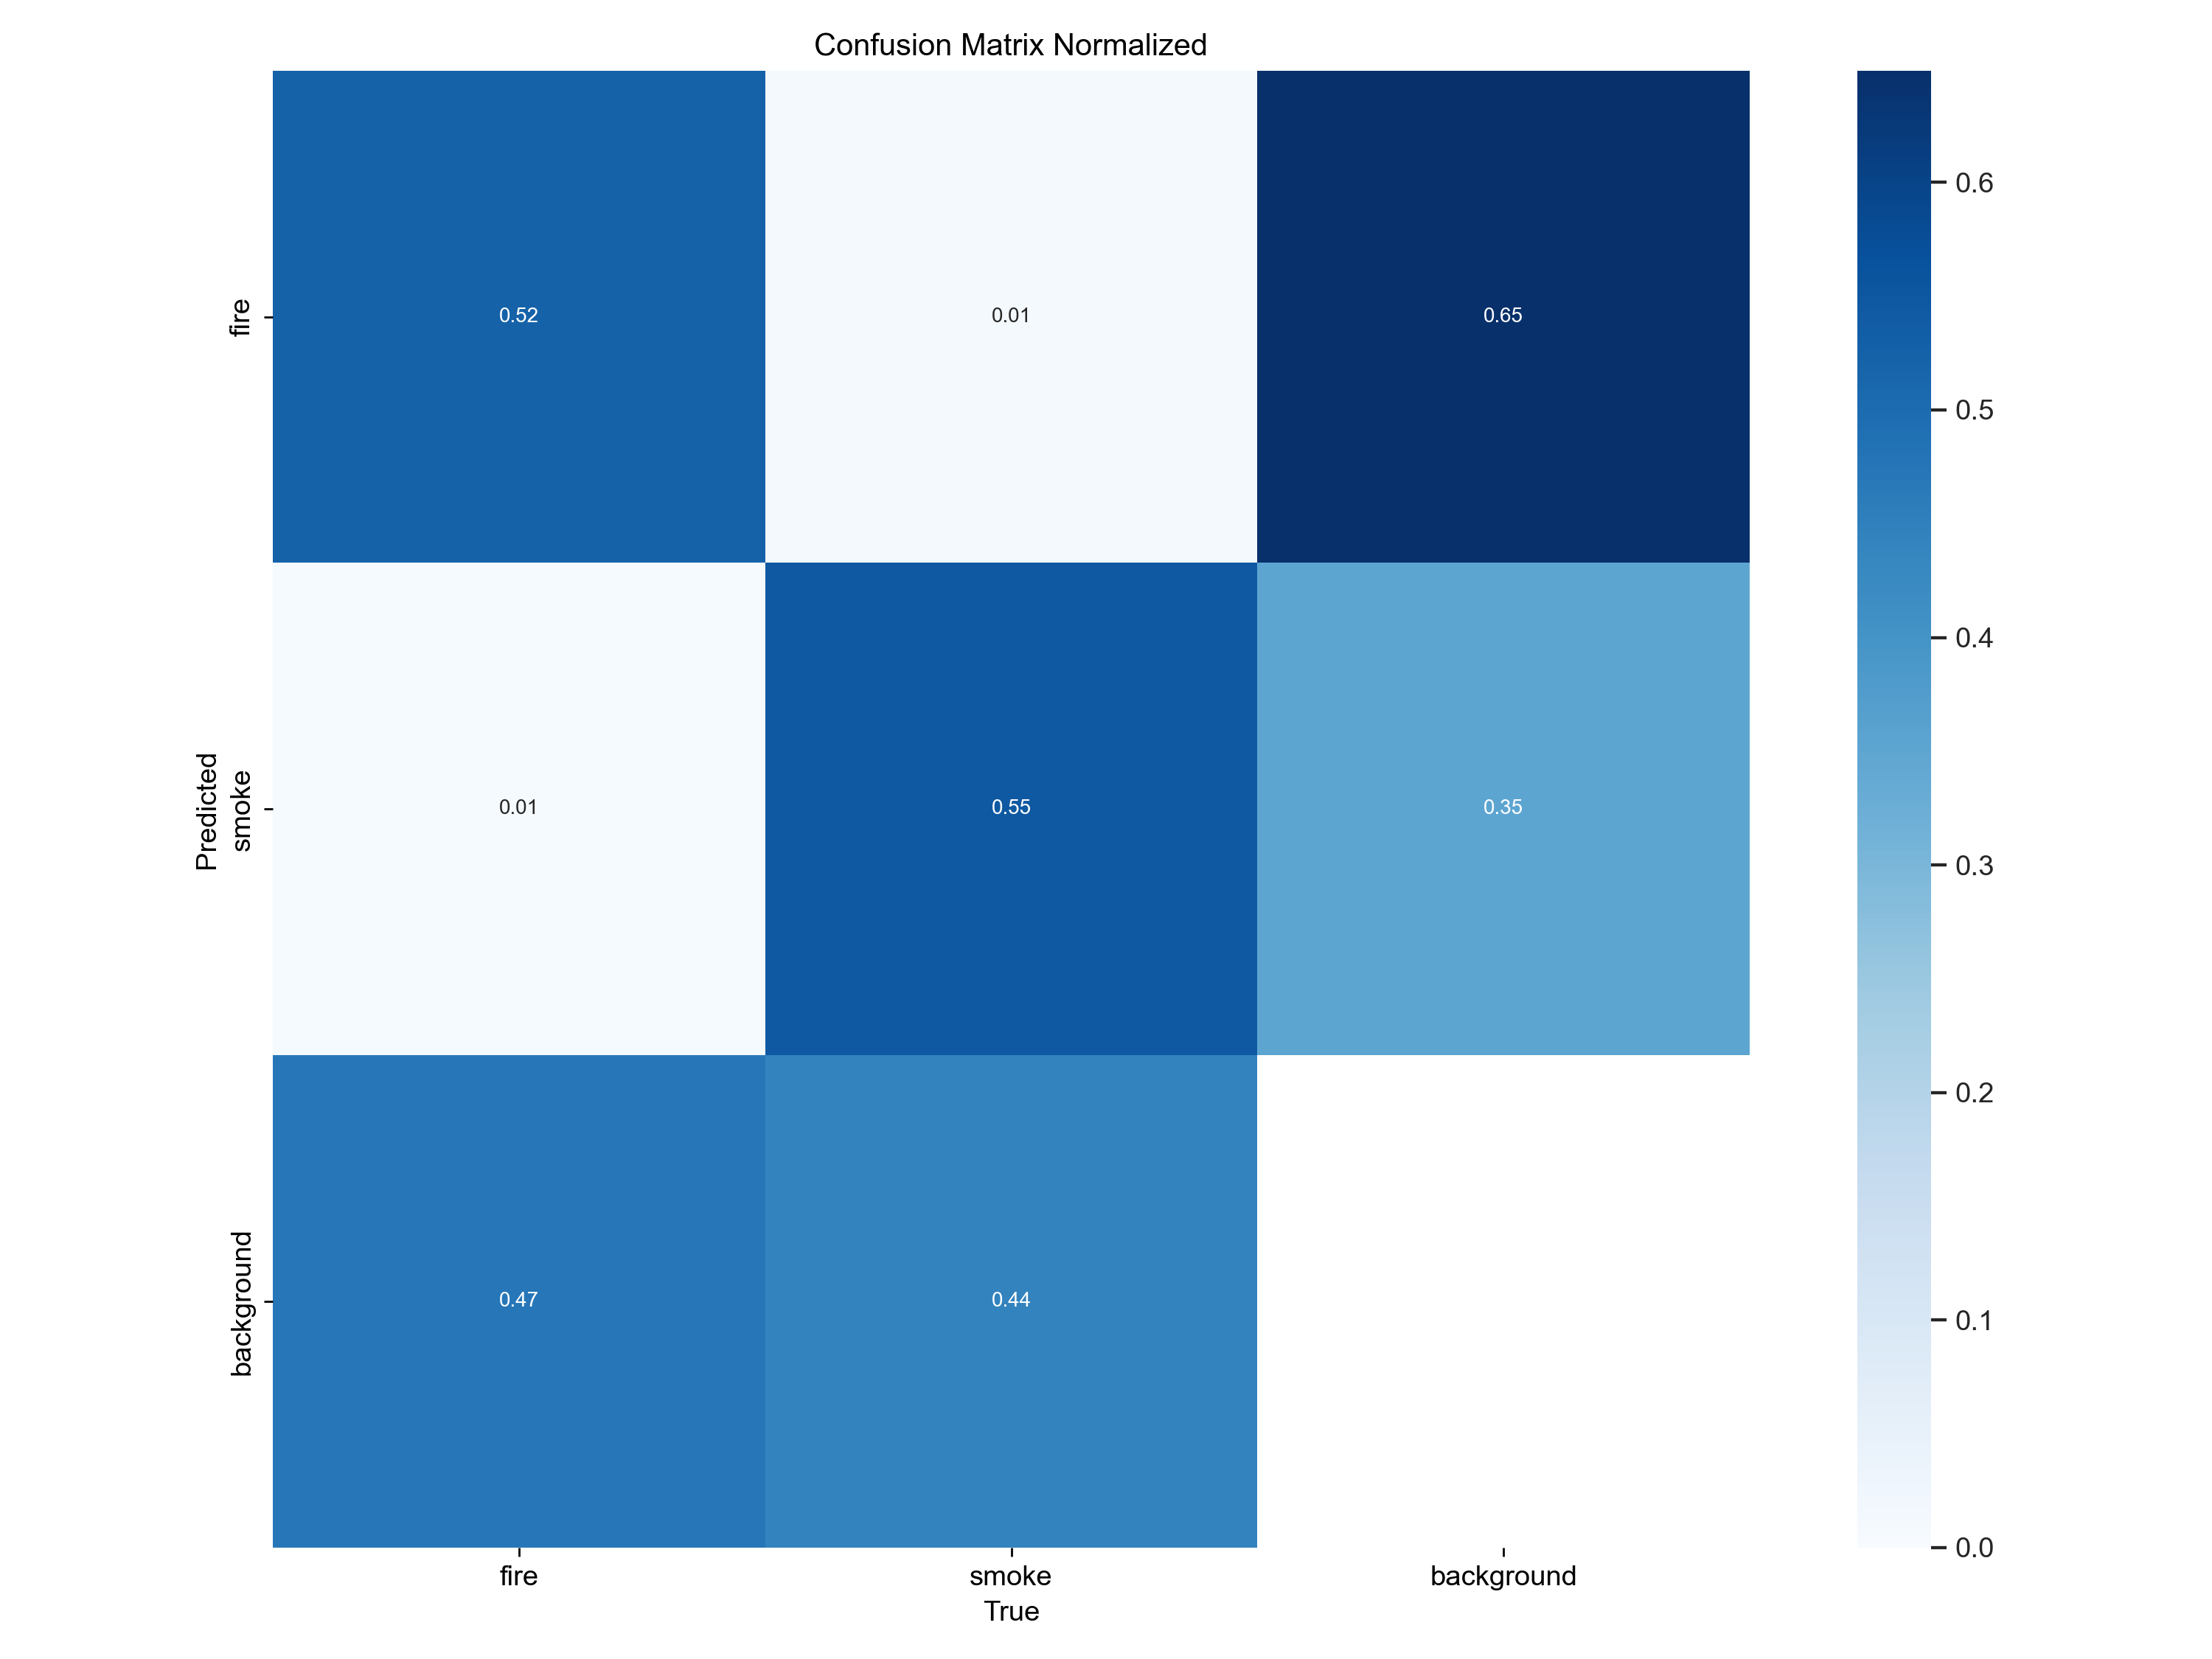

In [13]:
from IPython.display import Image

Image(filename='runs/detect/synthetic1500/confusion_matrix_normalized.png', width=1000)

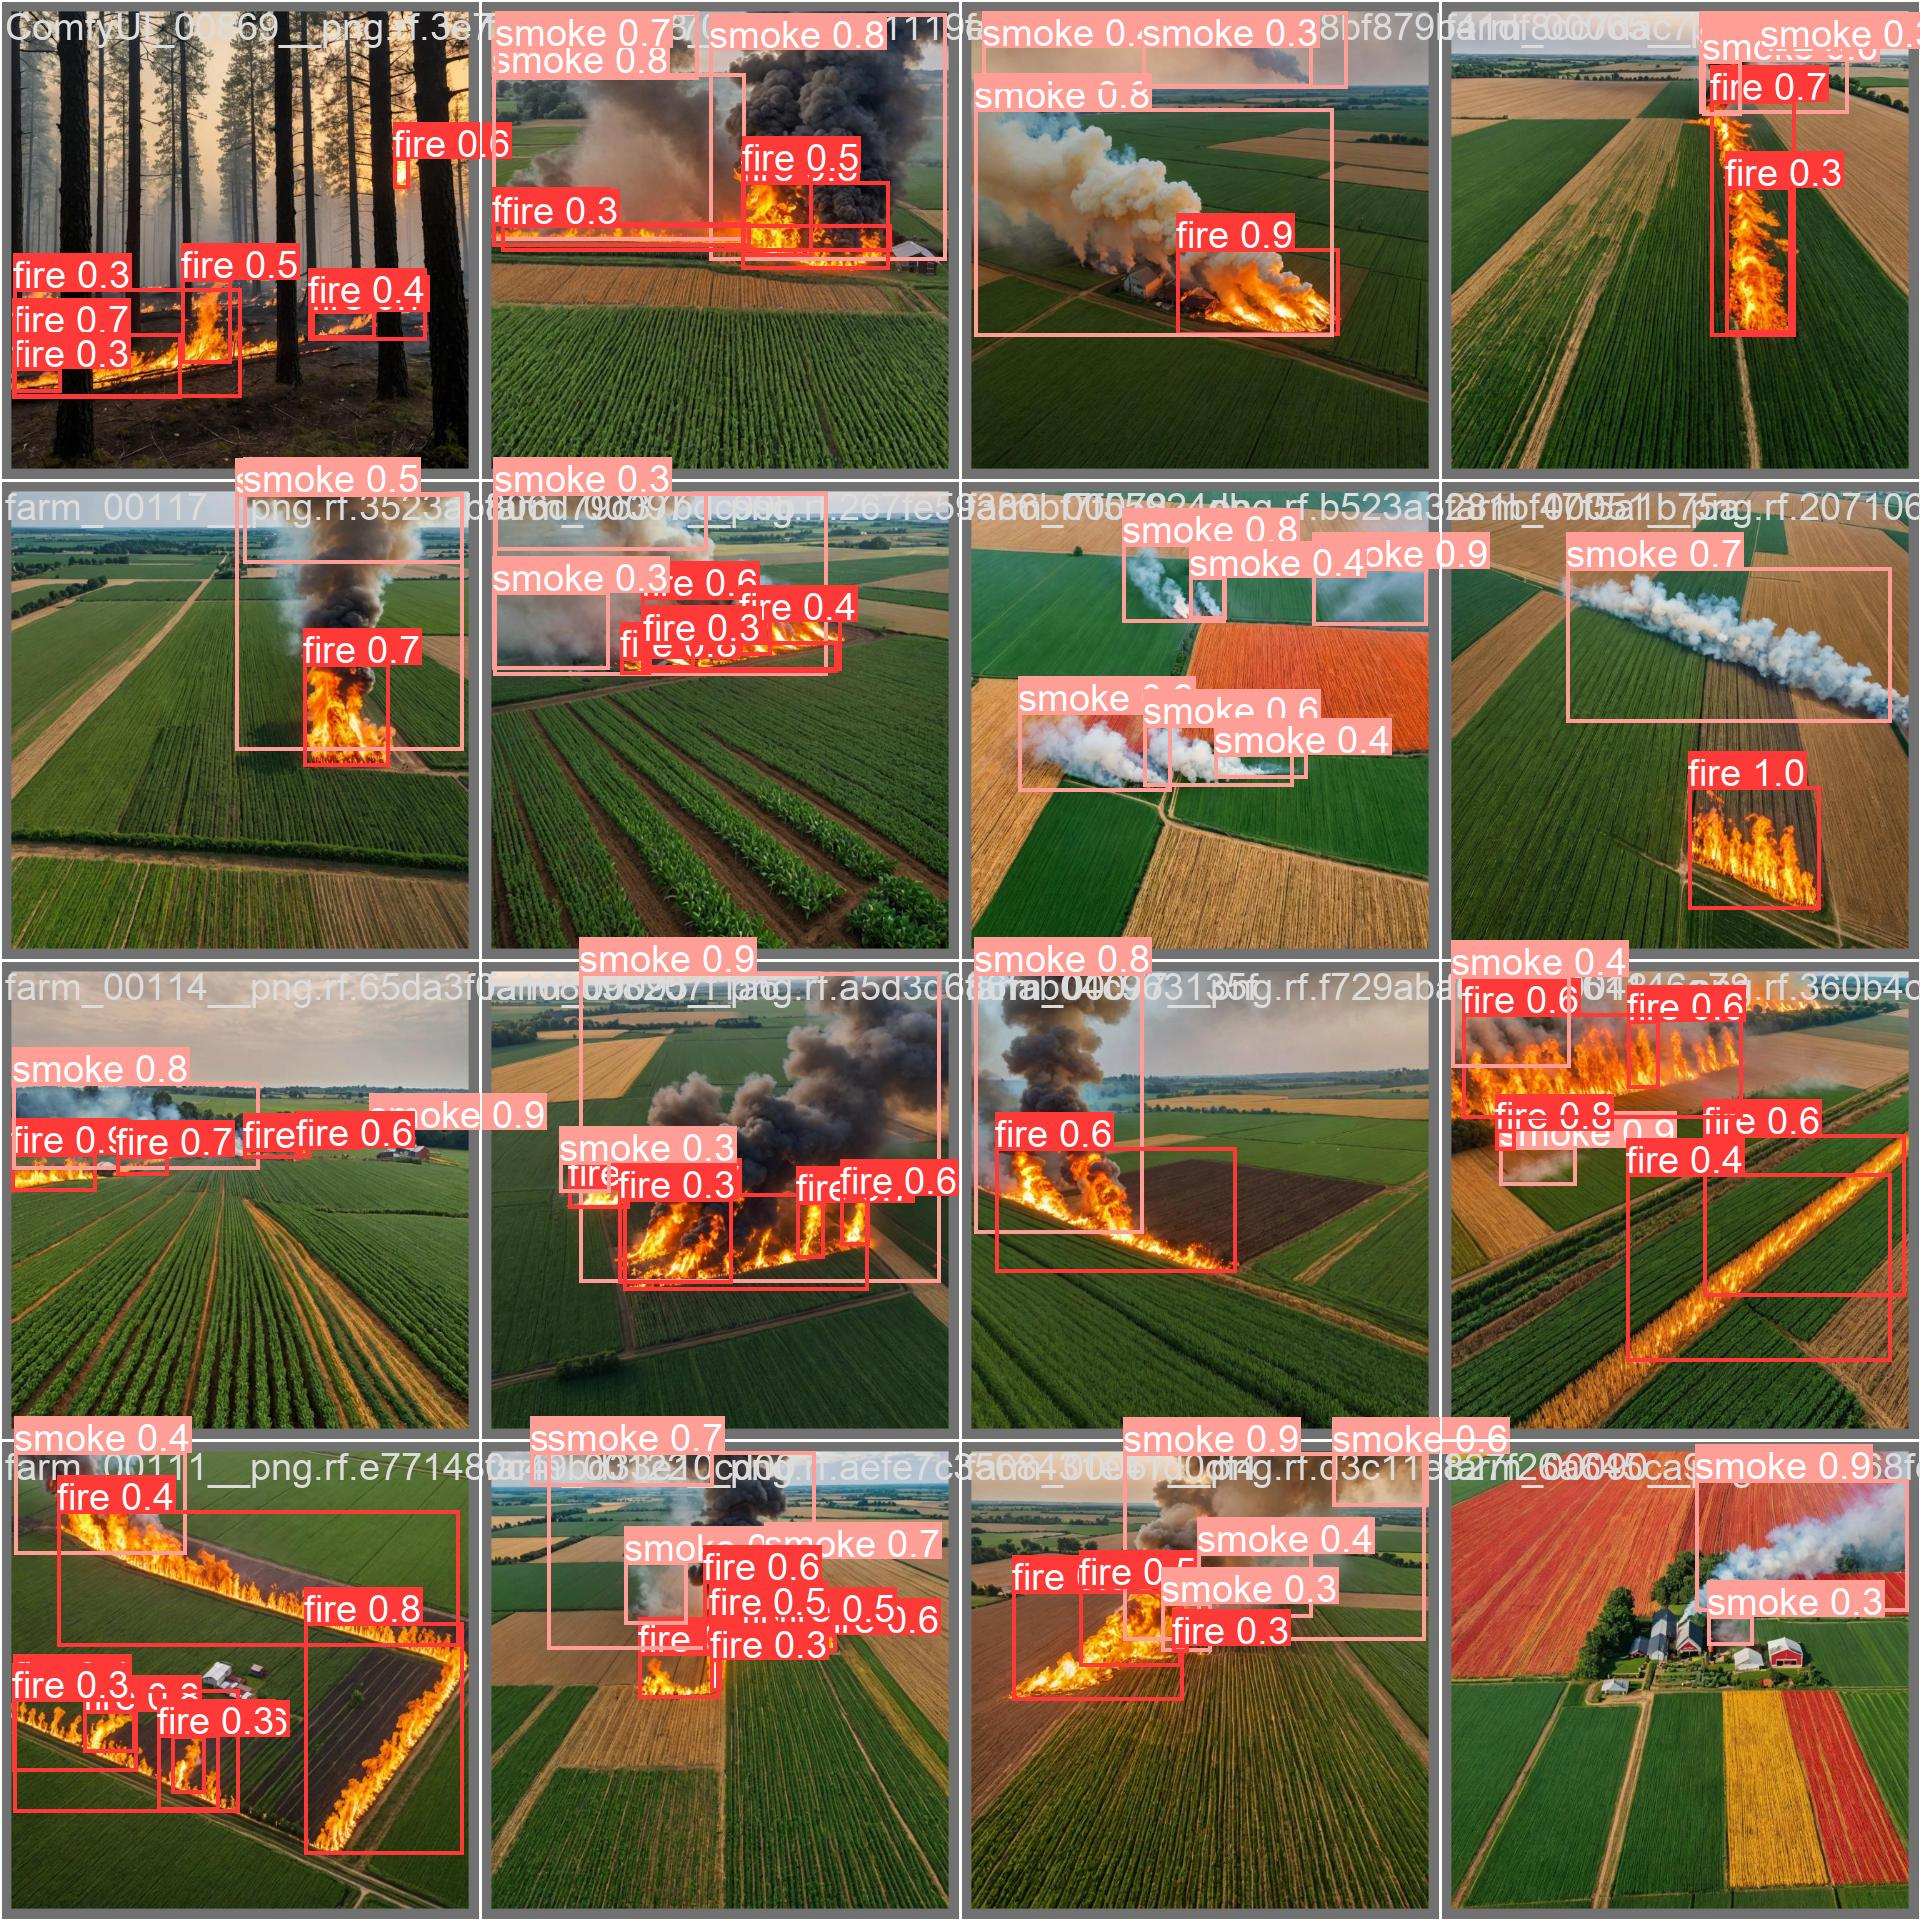

In [15]:
Image(filename='runs/detect/synthetic1500/val_batch0_pred.jpg', width=1000)

### 2.5 Validation on static testset

In [17]:
from ultralytics import YOLO

# Load a model
model = YOLO('runs/detect/synthetic1500/weights/best.pt')  # load a custom model

# Validate the model
metrics = model.val(data="testset-2/data.yaml", imgsz=640, save_json=True)  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category

Ultralytics YOLOv8.1.1 🚀 Python-3.11.3 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)


Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\ResearchProject\testset-2\valid\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.68it/s]


                   all        100        235      0.199      0.283      0.129     0.0464
                  fire        100        171      0.231      0.222      0.128     0.0469
                 smoke        100         64      0.166      0.344       0.13     0.0459
Speed: 1.2ms preprocess, 3.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Saving runs\detect\val3\predictions.json...
Results saved to runs\detect\val3


array([   0.046885,    0.045925])

In [18]:
metrics.box.map50 * 100

12.900421090958075

### 2.6 Running inference

In [ ]:
!yolo task=detect mode=predict model="runs/detect/synthetic1500/weights/best.pt" source="D:/ComfyUI/ComfyUI_windows_portable_nvidia_cu121_or_cpu/ComfyUI_windows_portable/ComfyUI/output_forest/ComfyUI_00901_.png" conf=0.25 line_width=1

In [ ]:
!yolo task=detect mode=predict model="runs/detect/synthetic1500/weights/best.pt" source="fire/fire3.mp4" conf=0.2 line_width=1

### 2.7 Upload

In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key="YOUR_API_KEY")
project = rf.workspace().project("synthetic1500")
project.version(1).deploy(model_type="yolov8", model_path=f"./runs/detect/synthetic1500/")